# ECE236A (Fall 2025)

This notebook shows **how to use** the provided `utils.py` and your `MySolution_{group_number}.py` for:
- **Task 1** (baseline classifier),
- **Task 2** (centralized compression),
- **Task 3.1** (per-sensor budget), **Task 3.2** (total budget), and
- **Task 3.3** (minimal bits for target accuracy).

It includes **commented-out** code blocks that you can enable after you implement your methods.
For now, we also include **mock results** to show the required plotting formats.

> **Important:** These cells are **guidelines**, not a complete solution. You may (and often should) adapt the code to:
> - output all required artifacts for the report (e.g., chosen allocations, validation choices, baselines),
> - plot additional figures that strengthen your analysis,
> - add helper functions/visualizations to support your arguments.
>
> This boilerplate demonstrates how to **wire up** the methods and plotting utilities. You’re responsible for producing all figures/results requested in the project handout.

In [1]:
from utils import *
from MySolution_14 import MyDecentralized, MyFeatureCompression, MyTargetAllocator # change MySolution to MySolution_{group_number}
import os
os.environ["MOSEKLM_LICENSE_FILE"] = r"C:\Users\awong\mosek\mosek.lic"

%load_ext autoreload
%autoreload 2

## Load datasets

Synthetic shapes: (800, 2) (800,)


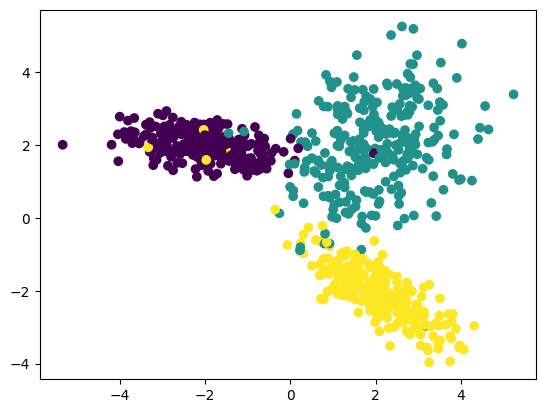

In [2]:
syn_data = prepare_synthetic_data()
print("Synthetic shapes:", syn_data['trainX'].shape, syn_data['trainY'].shape)
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY']); plt.show()

MNIST shapes: (800, 784) (800,)


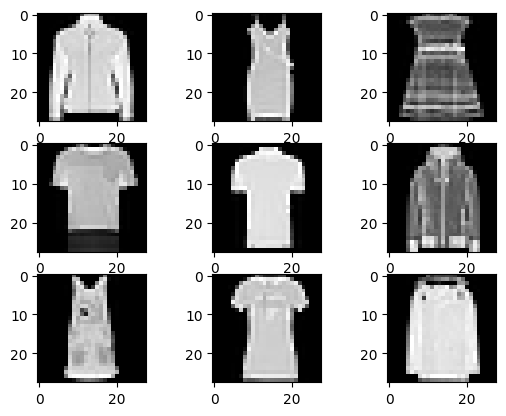

In [3]:
mnist_data = prepare_mnist_data()
print("MNIST shapes:", mnist_data['trainX'].shape, mnist_data['trainY'].shape)
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

## Task 1 — Baseline classifier (Decentralized class, no compression)
Uncomment the following once you've implemented `MyDecentralized.train/predict/score`.

In [4]:
np.sum(mnist_data['trainY']==4)

np.int64(260)

In [5]:
np.sum(mnist_data['trainY']==3)

np.int64(286)

In [6]:
np.sum(mnist_data['trainY']==0)

np.int64(254)

In [8]:
clf = MyDecentralized(K=3)
clf.train(mnist_data['trainX'], mnist_data['trainY'])  # if you need val, modify signature accordingly
task1_test_acc = clf.evaluate(mnist_data['testX'], mnist_data['testY'])
print("Task 1 test accuracy:", task1_test_acc)

(CVXPY) Nov 28 10:26:19 AM: Your problem has 7107 variables, 9504 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Nov 28 10:26:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 10:26:20 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 10:26:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 10:26:20 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 28 10:26:20 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 10:26:20 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 10:26:20 AM: Applying reduction Dcp2Cone


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 10:26:22 AM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 10:26:22 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 10:27:14 AM: Applying reduction MOSEK
(CVXPY) Nov 28 10:27:15 AM: Finished problem compilation (took 5.535e+01 seconds).
(CVXPY) Nov 28 10:27:15 AM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 10:27:16 AM: Problem
(CVXPY) Nov 28 10:27:16 AM:   Name                   :                 
(CVXPY) Nov 28 10:27:16 AM:   Objective sense        : maximize        
(CVXPY) Nov 28 10:27:16 AM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 10:27:16 AM:   Constraints            : 7107            
(CVXPY) Nov 28 10:27:16 AM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 10:27:16 AM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 10:27:16 AM:   Cones                  : 0               
(CVXPY) Nov 28 10:27:16 AM:   Scalar variables       : 9504            
(CVXPY) Nov 28 10:27:16 AM:   Matrix variables       : 0               
(CVXPY) Nov 28 10:27:16 AM:   Integer variables      : 0               
(CVXPY) Nov 28 10:27:16 AM: 
(CVXPY) Nov 28 10:27:16 AM: Optimizer started.
(CVXPY) Nov 28 10:27:16 AM: Folding started.
(CVXPY) Nov 28 10:27:16 AM: Folding: not applied.
(CVXPY) Nov 28 10:27:16 AM: Folding terminated. Time: 0.0

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Task 1 test accuracy: 0.908


### Notes on bit budgets

- **Uniform Scalar Quantization (USQ):**  
  The simplest baseline scheme is to quantize each feature (e.g., image pixel) independently using the same number of bits `b`.  
  The total budget is then `B_tot = M * b` with `M = 784` (28×28).  
  Example: `B_TOT_LIST = [784, 1568, 2352]` corresponds to **1 / 2 / 3 bits per feature** under USQ.  
  However, you can assign different bit-depths to different features, which would allow you to reach even lower budgets (e.g., `b=0` for some features).

- **Other quantizers:**  
  If you use non-uniform scalar, companded, or vector quantization, this direct formula may not apply.  
  In those cases, interpret `B_tot` as your **total bits per image** based on your quantizer design  
  (e.g., sum of bits for transmitted indices, parameters, or blocks).  
  - **If you transmit selectively (e.g., only send clustered or informative samples):**  
  Report your budget as the **average total bits per image across the full dataset**,  
  not just the bits for transmitted samples. This ensures fair comparison with methods  
  that send every image.

  Be explicit in your report about how you compute and compare bit budgets.

- **Decentralized setting:**  
  Each sensor has `d_s = 196` features; a per-sensor budget `k` corresponds to a local bit constraint.  
  In USQ, this implies a local bit-depth `b_s ≈ floor(k / d_s)`;  
  in more general designs, `k` is simply the total bits that sensor `s` is allowed to send per image.

- **No-quantization reference:**  
  Original (uncompressed) features are the upper bound.  
  For an 8-bit scalar baseline: `784 * 8 = 6272` bits/image.

- **Compare apples-to-apples:**  
  Use the same total budgets (`B_TOT_LIST`) across centralized and decentralized experiments,  
  but remember that the mapping between bits and quantization precision may differ depending on your quantizer.

## Task 2 — Centralized compression
Uncomment the following once you've implemented `MyFeatureCompression.run_centralized`.

Computing centroids...


(CVXPY) Nov 28 12:08:27 PM: Your problem has 204800 variables, 800 constraints, and 0 parameters.
(CVXPY) Nov 28 12:08:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:08:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:08:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:08:27 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 28 12:08:27 PM: Compiling problem (target solver=MOSEK).


                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:08:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:08:27 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:08:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:08:27 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 12:08:41 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:08:41 PM: Finished problem compilation (took 1.383e+01 seconds).
(CVXPY) Nov 28 12:08:41 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:08:41 PM: Problem
(CVXPY) Nov 28 12:08:41 PM:   Name                   :                 
(CVXPY) Nov 28 12:08:41 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:08:41 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:08:41 PM:   Constraints            : 800             
(CVXPY) Nov 28 12:08:41 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:08:41 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:08:41 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:08:41 PM:   Scalar variables       : 204800          
(CVXPY) Nov 28 12:08:41 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:08:41 PM:   Integer variables      : 204800          
(CVXPY) Nov 28 12:08:41 PM: 
(CVXPY) Nov 28 12:08:41 PM: Optimizer started.
(CVXPY) Nov 28 12:08:41 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:08:41 PM: Threads used: 8
(CVXPY) Nov 28 12:08:41 PM: Presolve started.
(

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:08:45 PM: Your problem has 204800 variables, 800 constraints, and 0 parameters.
(CVXPY) Nov 28 12:08:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:08:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:08:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:08:45 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 28 12:08:45 PM: Compiling problem (target solver=MOSEK).


                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:08:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:08:45 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:08:45 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:08:45 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 12:09:00 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:09:00 PM: Finished problem compilation (took 1.553e+01 seconds).
(CVXPY) Nov 28 12:09:00 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:09:01 PM: Problem
(CVXPY) Nov 28 12:09:01 PM:   Name                   :                 
(CVXPY) Nov 28 12:09:01 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:09:01 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:09:01 PM:   Constraints            : 800             
(CVXPY) Nov 28 12:09:01 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:09:01 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:09:01 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:09:01 PM:   Scalar variables       : 204800          
(CVXPY) Nov 28 12:09:01 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:09:01 PM:   Integer variables      : 204800          
(CVXPY) Nov 28 12:09:01 PM: 
(CVXPY) Nov 28 12:09:01 PM: Optimizer started.
(CVXPY) Nov 28 12:09:01 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:09:01 PM: Threads used: 8
(CVXPY) Nov 28 12:09:01 PM: Presolve started.
(

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:04 PM: Your problem has 204800 variables, 800 constraints, and 0 parameters.
(CVXPY) Nov 28 12:09:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:09:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:09:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:09:04 PM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:04 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 12:09:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:09:04 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:09:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:09:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 12:09:18 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:09:18 PM: Finished problem compilation (took 1.427e+01 seconds).
(CVXPY) Nov 28 12:09:18 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:09:19 PM: Problem
(CVXPY) Nov 28 12:09:19 PM:   Name                   :                 
(CVXPY) Nov 28 12:09:19 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:09:19 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:09:19 PM:   Constraints            : 800             
(CVXPY) Nov 28 12:09:19 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:09:19 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:09:19 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:09:19 PM:   Scalar variables       : 204800          
(CVXPY) Nov 28 12:09:19 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:09:19 PM:   Integer variables      : 204800          
(CVXPY) Nov 28 12:09:19 PM: 
(CVXPY) Nov 28 12:09:19 PM: Optimizer started.
(CVXPY) Nov 28 12:09:19 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:09:19 PM: Threads used: 8
(CVXPY) Nov 28 12:09:19 PM: Presolve started.
(

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:22 PM: Your problem has 204800 variables, 800 constraints, and 0 parameters.
(CVXPY) Nov 28 12:09:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:09:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:09:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:09:22 PM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Nov 28 12:09:22 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 12:09:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:09:22 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:09:22 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:09:22 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:36 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:09:36 PM: Finished problem compilation (took 1.429e+01 seconds).
(CVXPY) Nov 28 12:09:36 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:09:37 PM: Problem
(CVXPY) Nov 28 12:09:37 PM:   Name                   :                 
(CVXPY) Nov 28 12:09:37 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:09:37 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:09:37 PM:   Constraints            : 800             
(CVXPY) Nov 28 12:09:37 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:09:37 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:09:37 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:09:37 PM:   Scalar variables       : 204800          
(CVXPY) Nov 28 12:09:37 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:09:37 PM:   Integer variables      : 204800          
(CVXPY) Nov 28 12:09:37 PM: 
(CVXPY) Nov 28 12:09:37 PM: Optimizer started.
(CVXPY) Nov 28 12:09:37 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:09:37 PM: Threads used: 8
(CVXPY) Nov 28 12:09:37 PM: Presolve started.
(

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:40 PM: Your problem has 204800 variables, 800 constraints, and 0 parameters.
(CVXPY) Nov 28 12:09:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:09:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:09:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:09:40 PM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Nov 28 12:09:40 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 12:09:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:09:40 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:09:40 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:09:40 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:09:54 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:09:54 PM: Finished problem compilation (took 1.438e+01 seconds).
(CVXPY) Nov 28 12:09:54 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:09:55 PM: Problem
(CVXPY) Nov 28 12:09:55 PM:   Name                   :                 
(CVXPY) Nov 28 12:09:55 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:09:55 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:09:55 PM:   Constraints            : 800             
(CVXPY) Nov 28 12:09:55 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:09:55 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:09:55 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:09:55 PM:   Scalar variables       : 204800          
(CVXPY) Nov 28 12:09:55 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:09:55 PM:   Integer variables      : 204800          
(CVXPY) Nov 28 12:09:55 PM: 
(CVXPY) Nov 28 12:09:55 PM: Optimizer started.
(CVXPY) Nov 28 12:09:55 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:09:55 PM: Threads used: 8
(CVXPY) Nov 28 12:09:55 PM: Presolve started.
(

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Finished computing centroids
Training classifier...
                                     CVXPY                                     
                                     v1.7.2                                    


(CVXPY) Nov 28 12:09:59 PM: Your problem has 7107 variables, 9504 constraints, and 0 parameters.
(CVXPY) Nov 28 12:10:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:10:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:10:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:10:00 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 28 12:10:01 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 12:10:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:10:01 PM: Applying reduction Dcp2Cone


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:10:03 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:10:03 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 12:11:00 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:11:01 PM: Finished problem compilation (took 6.158e+01 seconds).
(CVXPY) Nov 28 12:11:01 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:11:02 PM: Problem
(CVXPY) Nov 28 12:11:02 PM:   Name                   :                 
(CVXPY) Nov 28 12:11:02 PM:   Objective sense        : maximize        
(CVXPY) Nov 28 12:11:02 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:11:02 PM:   Constraints            : 7107            
(CVXPY) Nov 28 12:11:02 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:11:02 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:11:02 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:11:02 PM:   Scalar variables       : 9504            
(CVXPY) Nov 28 12:11:02 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:11:02 PM:   Integer variables      : 0               
(CVXPY) Nov 28 12:11:02 PM: 
(CVXPY) Nov 28 12:11:02 PM: Optimizer started.
(CVXPY) Nov 28 12:11:03 PM: Folding started.
(CVXPY) Nov 28 12:11:03 PM: Folding factor: 0.72.
(CVXPY) Nov 28 12:11:03 PM: Folding terminated. Time: 0.1

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Finished training classifier


(CVXPY) Nov 28 12:11:08 PM: Your problem has 128000 variables, 500 constraints, and 0 parameters.
(CVXPY) Nov 28 12:11:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 12:11:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 12:11:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 12:11:08 PM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 28 12:11:08 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 28 12:11:08 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 28 12:11:08 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 28 12:11:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 28 12:11:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 28 12:11:14 PM: Applying reduction MOSEK
(CVXPY) Nov 28 12:11:15 PM: Finished problem compilation (took 6.312e+00 seconds).
(CVXPY) Nov 28 12:11:15 PM: Invoking solver MOSEK  to obtain a solution.
(CVXPY) Nov 28 12:11:15 PM: Problem


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Nov 28 12:11:15 PM:   Name                   :                 
(CVXPY) Nov 28 12:11:15 PM:   Objective sense        : minimize        
(CVXPY) Nov 28 12:11:15 PM:   Type                   : LO (linear optimization problem)
(CVXPY) Nov 28 12:11:15 PM:   Constraints            : 500             
(CVXPY) Nov 28 12:11:15 PM:   Affine conic cons.     : 0               
(CVXPY) Nov 28 12:11:15 PM:   Disjunctive cons.      : 0               
(CVXPY) Nov 28 12:11:15 PM:   Cones                  : 0               
(CVXPY) Nov 28 12:11:15 PM:   Scalar variables       : 128000          
(CVXPY) Nov 28 12:11:15 PM:   Matrix variables       : 0               
(CVXPY) Nov 28 12:11:15 PM:   Integer variables      : 128000          
(CVXPY) Nov 28 12:11:15 PM: 
(CVXPY) Nov 28 12:11:15 PM: Optimizer started.
(CVXPY) Nov 28 12:11:15 PM: Mixed integer optimizer started.
(CVXPY) Nov 28 12:11:15 PM: Threads used: 8
(CVXPY) Nov 28 12:11:15 PM: Presolve started.
(CVXPY) Nov 28 12:11:16 PM: Presolve 

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


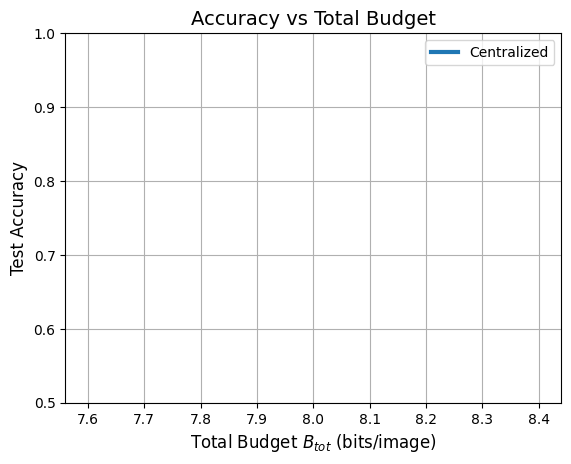

In [11]:
fc = MyFeatureCompression(K=3)
# B_tot_list = [100, 400, 784, 1568, 2352, 3136]  # example budgets (you can modify)
B_tot_list = [8]  # example budgets (you can modify)
res_central = fc.run_centralized(
    mnist_data['trainX'], mnist_data['trainY'],
    mnist_data['valX'],   mnist_data['valY'],
    mnist_data['testX'],  mnist_data['testY'],
    B_tot_list=B_tot_list,
)
plot_result_total(result2=res_central, result3_2=None)

In [13]:
print(res_central['test_accuracy'])

[0.872]


## Task 3.1 — Decentralized: fixed per-sensor budget
Uncomment the following once you've implemented `MyFeatureCompression.run_decentralized_per_sensor`.

In [ ]:
# I_train, Xtr_blocks = split_into_quadrants(mnist_data['trainX'])
# _,       Xva_blocks = split_into_quadrants(mnist_data['valX'])
# _,       Xte_blocks = split_into_quadrants(mnist_data['testX'])

# k_list = [25, 100, 196, 392, 588, 784] # example budgets (you can modify)
# res_k = fc.run_decentralized_per_sensor(
#     Xtr_blocks, Xva_blocks, Xte_blocks,
#     mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
#     k_list=k_list,
# )
# res_k['baseline_test_accuracy_task1'] = task1_test_acc
# plot_result_per_sensor(result3_1=res_k)

## Task 3.2 — Decentralized: total bit budget
Uncomment the following once you've implemented `MyFeatureCompression.run_decentralized_total`.

In [ ]:
# B_tot_list = [100, 400, 784, 1568, 2352, 3136]  # example budgets (you can modify)
# res_B = fc.run_decentralized_total(
#     Xtr_blocks, Xva_blocks, Xte_blocks,
#     mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
#     B_tot_list=B_tot_list,
# )
# plot_result_total(result2=None, result3_2=res_B)

In [ ]:
# # overlay centralized vs decentralized
# res_compare = {
#     'centralized':   res_central,
#     'decentralized': res_B,
# }
# plot_result_centralized_vs_decentralized(result=res_compare)

## Task 3.3 — Minimal bits for target accuracy
Uncomment once you've implemented `MyTargetAllocator` methods.

In [ ]:
# ta = MyTargetAllocator(K=3)
# alphas = [0.6, 0.7, 0.8, 0.9, 0.95]  # or choose based on your curves
# B_grid = [100, 400, 784, 1568, 2352, 3136]  # example budgets (you can modify)
# cent_min = []
# decz_min = []
# for a in alphas:
#     Bc = ta.minimal_bits_centralized(fc, mnist_data['trainX'], mnist_data['trainY'],
#                                      mnist_data['valX'],   mnist_data['valY'],
#                                      mnist_data['testX'],  mnist_data['testY'],
#                                      alpha=a, B_grid=B_grid)
#     Bd, alloc = ta.minimal_bits_decentralized(fc, Xtr_blocks, Xva_blocks, Xte_blocks,
#                                               mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
#                                               alpha=a, B_grid=B_grid)
#     cent_min.append(Bc)
#     decz_min.append(Bd)
# res_target = {'alphas': alphas, 'centralized_min_bits': cent_min, 'decentralized_min_bits': decz_min}
# plot_result_target(result=res_target)

## Mock results (for plotting format only)

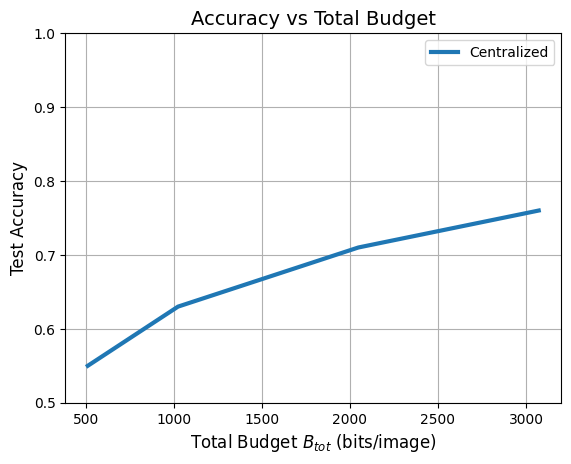

In [2]:
# --- Task 2 (centralized) mock ---
mock_res_central = {
    'B_tot': [512, 1024, 2048, 3072],
    'test_accuracy': [0.55, 0.63, 0.71, 0.76],
}
plot_result_total(result2=mock_res_central, result3_2=None)

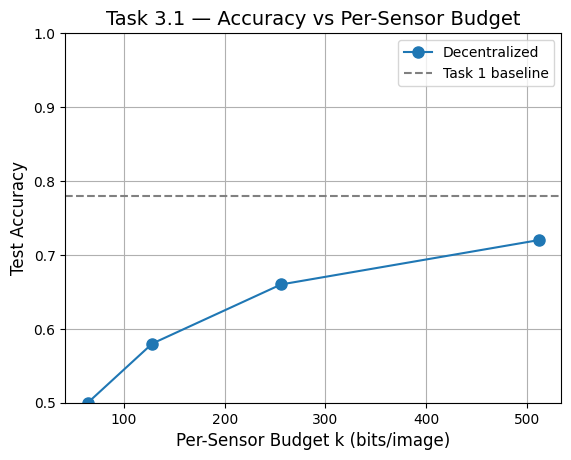

In [3]:
# --- Task 3.1 (per-sensor) mock ---
mock_res_k = {
    'k': [64, 128, 256, 512],
    'test_accuracy': [0.50, 0.58, 0.66, 0.72],
    'baseline_test_accuracy_task1': 0.78,
    'b_s': [(0,0,0,0),(1,1,1,1),(2,2,2,2),(4,4,4,4)],
}
plot_result_per_sensor(result3_1=mock_res_k)

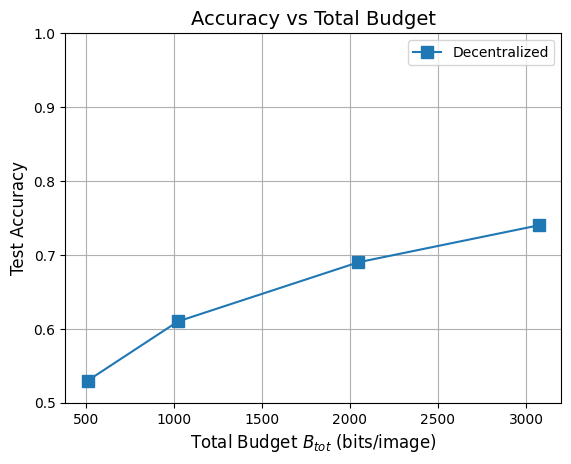

In [4]:
# --- Task 3.2 (total budget) mock ---
mock_res_B = {
    'B_tot': [512, 1024, 2048, 3072],
    'test_accuracy': [0.53, 0.61, 0.69, 0.74],
    'best_allocation': [(0,2,2,2),(1,1,2,2),(2,2,2,2),(3,3,2,2)],
}
plot_result_total(result2=None, result3_2=mock_res_B)

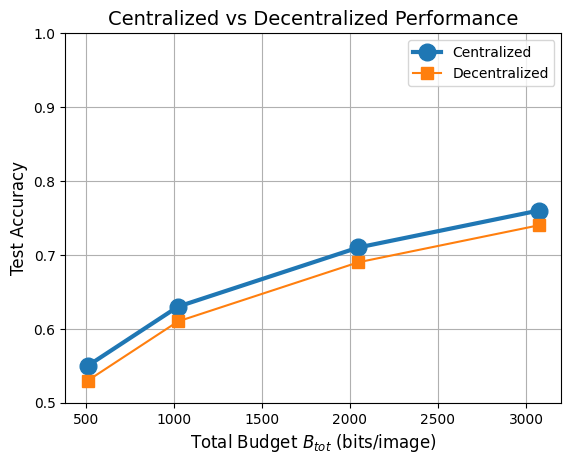

In [5]:
# --- Centralized vs Decentralized overlay (mock) ---
plot_result_centralized_vs_decentralized(result={
    'centralized': mock_res_central,
    'decentralized': mock_res_B,
})

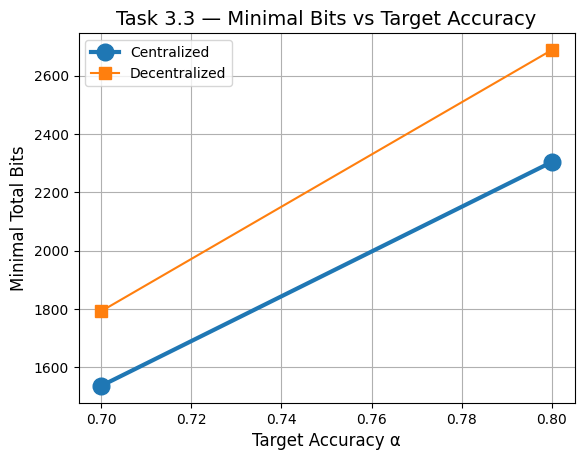

In [6]:
# --- Task 3.3 (target accuracy) mock ---
mock_res_target = {
    'alphas': [0.7, 0.8, 0.9],
    'centralized_min_bits': [1536, 2304, None],
    'decentralized_min_bits': [1792, 2688, None],
}
plot_result_target(result=mock_res_target)